In [8]:
#from utils.functions import *
import glob
import torch
from torch.utils.data import Dataset, DataLoader
import os
import multiprocessing as mp
from torchvision.transforms import CenterCrop
import random
import numpy as np
np.set_printoptions(threshold=np.inf)
from PIL import Image

In [9]:
import torch
import cv2
from utils.sam_loss import SamLoss
from utils.sam_forward import SamForward
from segment_anything import sam_model_registry
from utils.functions import loadimg
from utils.functions import loadmask
from copy import deepcopy
import matplotlib.pyplot as plt
from utils.visual import *
import glob
import shutil
from random import sample
import numpy as np
from torchvision.transforms import CenterCrop

In [10]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

In [43]:
# load original model
checkpoint = 'model/sam_vit_b_01ec64.pth'
device = 'cpu'
sam = sam_model_registry['vit_b'](
    checkpoint=checkpoint)  # ViT-Huge

# load fine-tuned decoder
model_path = r'C:/work/Project/AI/0317/SAM-Finetune-v3/model/'
sam_tuned = deepcopy(sam)
sam_tuned.mask_decoder.load_state_dict(torch.load(model_path + 'finetuned_decoder_epoch97_batch0582_score0.4964.pth'))
# sam_tuned_log = torch.load(model_path+'finetuned_decoder_epoch49_batch0980_score0.8597.ptlog')

sam.to(device)
sam_tuned.to(device)
sam.eval()
sam_tuned.eval()

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


In [44]:
# path_label = 'C:/work/Project/AI/RSPrompter-cky/data/WHU/val/label/val_206.tif'
# path_img = 'C:/work/Project/AI/RSPrompter-cky/data/WHU/val/image/val_206.tif'

path_label = 'C:/work/Project/AI/RSPrompter-cky/data/WHU/val/label/1_2_3.tif'
path_img = 'C:/work/Project/AI/RSPrompter-cky/data/WHU/val/image/1_2_3.tif'

image = Image.open(path_img)
img_label = torch.from_numpy(np.array(image)).unsqueeze(0)
label = Image.open(path_label)
mask_label = torch.from_numpy(np.array(label)).unsqueeze(0)

mask_label = mask_label[:,:,:,0]
mask_label = np.array(mask_label,dtype=bool)
mask_label = torch.from_numpy(np.array(mask_label))
print(mask_label.shape)
print(mask_label)

torch.Size([1, 512, 512])
tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])


In [45]:
 # 未微调模型预测
masks, iou_predictions, low_res_masks = SamForward(sam, img_label, mask_label, device=device)
# 微调模型预测
masks_tuned, iou_predictions_tuned, low_res_masks_tuned = SamForward(sam_tuned, img_label, mask_label, device=device)

# 标签后处理
mask_label = mask_label.type(torch.bool)
mask_label = mask_label > sam.mask_threshold
# 模型结果后处理
masks = (masks > sam.mask_threshold).cpu()
masks_tuned = (masks_tuned > sam.mask_threshold).cpu()

# evaluate
score = SamLoss().iou_logits(masks, mask_label)
score_tuned = SamLoss().iou_logits(masks_tuned, mask_label)

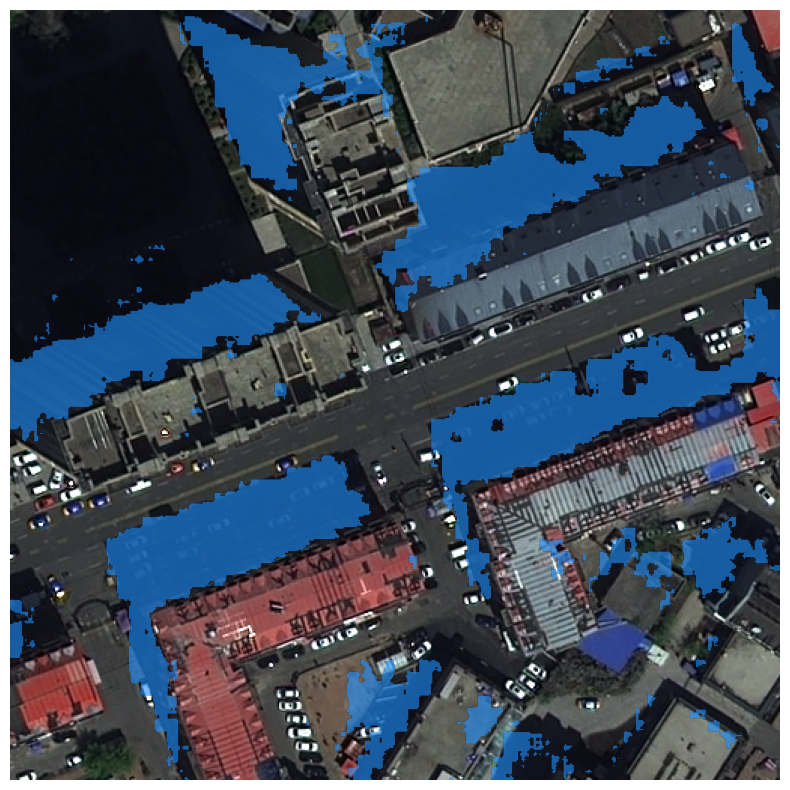

In [46]:
# 绘图(微调模型的结果)
plt.figure(figsize=(10,10))
plt.imshow(np.array(image))
show_mask(masks_tuned, plt.gca())
plt.axis('off')
plt.show()


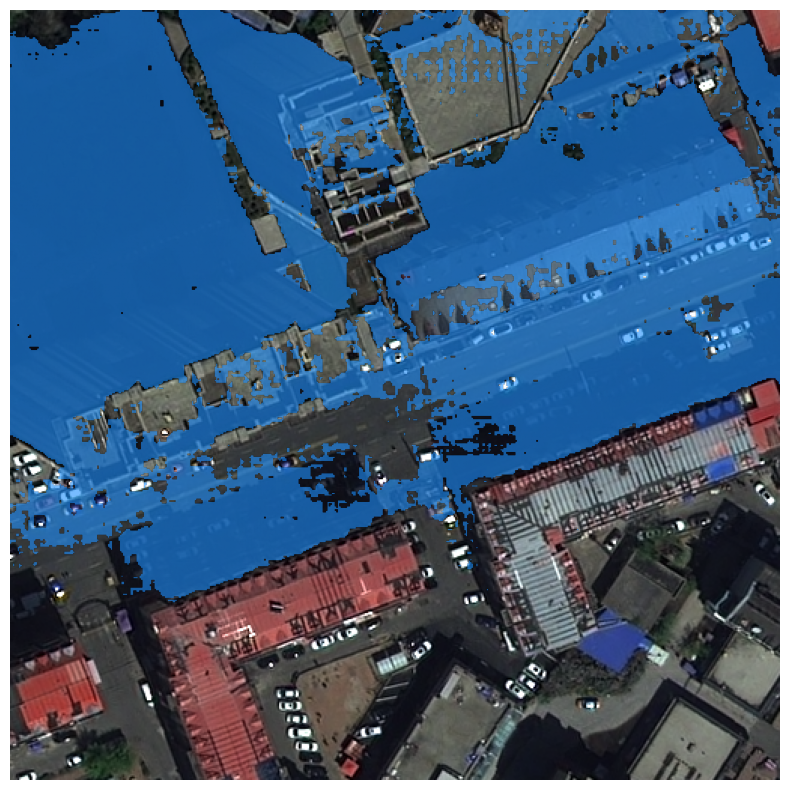

In [47]:
# 绘图(普通模型的结果)
plt.figure(figsize=(10,10))
plt.imshow(np.array(image))
show_mask(masks, plt.gca())
plt.axis('off')
plt.show()

In [8]:
path_label = 'C:/work/Project/AI/RSPrompter-cky/data/WHU/temp/label_s/1_4_2.tif/'
path_img = 'C:/work/Project/AI/RSPrompter-cky/data/WHU/temp/image-s/1_4_2.tif/'
path_output = 'C:/work/Project/AI/RSPrompter-cky/data/WHU/temp/output_o/'
filelist = os.listdir(path_label)

scores = []
scores_tuned = []

for item in filelist:
    # 数据加载与处理
    image = Image.open(path_img + item)
    img_label = torch.from_numpy(np.array(image)).unsqueeze(0)
    label = Image.open(path_label + item)
    mask_label = torch.from_numpy(np.array(label)).unsqueeze(0)
    
    # 未微调模型预测
    masks, iou_predictions, low_res_masks = SamForward(sam, img_label, mask_label, device=device)
    # 微调模型预测
    masks_tuned, iou_predictions_tuned, low_res_masks_tuned = SamForward(sam_tuned, img_label, mask_label, device=device)
    
    # 标签后处理
    mask_label = mask_label.type(torch.bool)
    mask_label = mask_label > sam.mask_threshold
    # 模型结果后处理
    masks = (masks > sam.mask_threshold).cpu()
    masks_tuned = (masks_tuned > sam.mask_threshold).cpu()
    
    # evaluate
    score = SamLoss().iou_logits(masks, mask_label)
    score_tuned = SamLoss().iou_logits(masks_tuned, mask_label)
    
    # 绘图(微调模型的结果)
    plt.figure(figsize=(10,10))
    plt.imshow(np.array(image))
    show_mask(masks_tuned, plt.gca())
    plt.axis('off')
    plt.savefig(path_output+item+"_tuned.png", dpi=50, bbox_inches='tight')
    plt.close()
    # 绘图(普通模型的结果)
    plt.figure(figsize=(10,10))
    plt.imshow(np.array(image))
    show_mask(masks, plt.gca())
    plt.axis('off')
    plt.savefig(path_output+item+"_untune.png", dpi=50, bbox_inches='tight')
    plt.close()
    # 绘图(mask叠加原图)
    plt.figure(figsize=(10,10))
    plt.imshow(np.array(image))
    show_mask(mask_label, plt.gca())
    plt.axis('off')
    plt.savefig(path_output+item+"_masked.png", dpi=50, bbox_inches='tight')
    plt.close()
    
    scores.append(score)
    scores_tuned.append(score_tuned)
    
    print("图片{} 处理完成！score_untune: {} score_tuned {}".format(str(item),float(score),float(score_tuned)))

print('微调模型的平均交并比：{}'.format(float(sum(scores_tuned) / len(scores_tuned))))
print('普通模型的平均交并比：{}'.format(float(sum(scores) / len(scores))))

图片val_1028.tif 处理完成！score_untune: 0.6355251669883728 score_tuned 0.8931580185890198
图片val_1029.tif 处理完成！score_untune: 0.35782983899116516 score_tuned 0.9167443513870239
图片val_1030.tif 处理完成！score_untune: 0.404696524143219 score_tuned 0.921704113483429
图片val_1031.tif 处理完成！score_untune: 0.5279715061187744 score_tuned 0.9229666590690613
图片val_1032.tif 处理完成！score_untune: 0.20711350440979004 score_tuned 0.8813256621360779
图片val_1033.tif 处理完成！score_untune: 0.49703773856163025 score_tuned 0.8932594060897827
图片val_1034.tif 处理完成！score_untune: 0.3981451094150543 score_tuned 0.8999740481376648
图片val_1035.tif 处理完成！score_untune: 0.35354697704315186 score_tuned 0.9166369438171387
图片val_819.tif 处理完成！score_untune: 0.343054860830307 score_tuned 0.8961727619171143
图片val_820.tif 处理完成！score_untune: 0.479726642370224 score_tuned 0.9084538817405701
图片val_821.tif 处理完成！score_untune: 0.4861980378627777 score_tuned 0.9123218059539795
图片val_822.tif 处理完成！score_untune: 0.4405915439128876 score_tuned 0.8346168398857

In [9]:
print('微调模型的平均交并比：{}'.format(float(sum(scores_tuned) / len(scores_tuned))))
print('普通模型的平均交并比：{}'.format(float(sum(scores) / len(scores))))

微调模型的平均交并比：0.8817842602729797
普通模型的平均交并比：0.38887542486190796


In [60]:
# 将分割图和原图合在一起
from PIL import Image
import matplotlib.pyplot as plt

path_label = 'C:/work/IMG/traindata/image-1-s/1_7_3.tif'
path_img = 'C:/work/IMG/traindata/label-s/1_7_3.tif'

#image1 原图 
#image2 分割图
image1 = Image.open(path_label)
image2 = Image.open(path_img)
 
image1 = image1.convert('RGBA')
image2 = image2.convert('RGBA')
 
#两幅图像进行合并时，按公式：blended_img = img1 * (1 – alpha) + img2* alpha 进行
image = Image.blend(image1,image2,0.7)
# image.save("test.png")
image.show()